# Bayesian inversion

This notebook will focus on solving inverse problems in a bayesian framework using PyLops linear operators

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import scooby

from scipy.linalg import lstsq, toeplitz, cholesky
from scipy.sparse.linalg import lsqr
from pylops import LinearOperator
from pylops.utils import dottest

np.random.seed(0)

## Problem definition

The problem that we are going to consider is generally referred to
as the *data reconstruction* problem and aims at reconstructing a regularly
sampled signal of size $M$ from $N$ randomly selected samples:

\begin{align}\mathbf{d} = \mathbf{R} \mathbf{m}\end{align}

where the restriction operator $\mathbf{R}$ that selects the $M$
elements from $\mathbf{m}$ at random locations is implemented using `pylops.Restriction`, and

\begin{align}\mathbf{d}= [d_1, d_2,...,d_N]^T, \qquad
    \mathbf{m}= [m_1, m_2,...,m_M]^T, \qquad\end{align}

with $M>>N$.

Let's first create the data in the frequency domain. The data is composed
by the superposition of 3 sinusoids with different frequencies. We then use the `pylops.FFT` operator to obtain the time domain version of the signal.

In [2]:
# input signal parameters
ifreqs = [41, 25, 66]
amps = [1., 1., 1.]
nt = 200
nfft = 2**11
dt = 0.004
t = np.arange(nt)*dt
f = np.fft.rfftfreq(nfft, dt)

# input signal in frequency domain
X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = amps

# input signal in time domain
FFTop = pylops.signalprocessing.FFT(nt, nfft=nfft, real=True)
x = FFTop.H*X

We now define the locations at which the signal will be sampled, apply forward, adjoint and inverse

In [61]:
# sampling locations    
perc_subsampling = 0.2
ntsub = int(np.round(nt*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nt))[:ntsub])
iava[-1] = nt-1 # assume we have the last sample to avoid instability

# create operator
Rop = pylops.Restriction(nt, iava, dtype='float64')

# create noise
sigma=1e-2
n = np.random.normal(0, sigma, nt)

# apply forward
y = Rop*x
yn = Rop*(x + n)
ymask = Rop.mask(x)
ynmask = Rop.mask(x + n)

# apply adjoint
xadj = Rop.H*yn

# apply inverse
xinv = Rop / yn

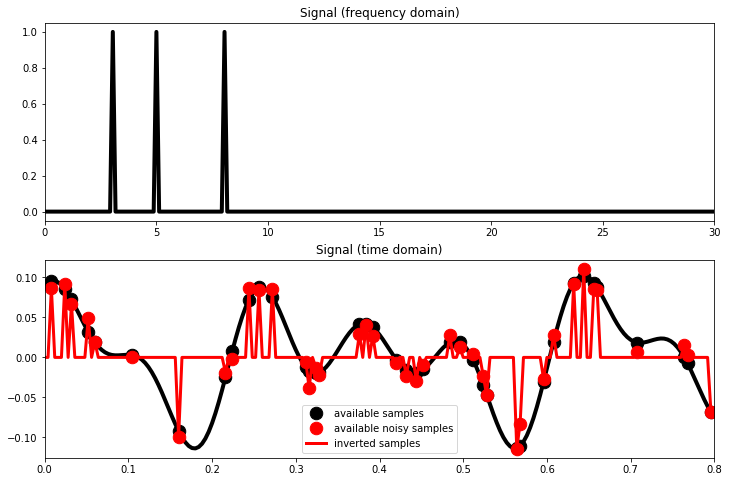

In [62]:
# Visualize
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(f, np.abs(X), 'k', lw=4)
axs[0].set_xlim(0, 30)
axs[0].set_title('Signal (frequency domain)')
axs[1].plot(t, x, 'k', lw=4)
axs[1].plot(t, ymask, '.k', ms=25, label='available samples')
axs[1].plot(t, ynmask, '.r', ms=25, label='available noisy samples')
axs[1].plot(t, xinv, 'r', lw=3, label='inverted samples')
axs[1].legend()
axs[1].set_title('Signal (time domain)')
axs[1].set_xlim(0, 0.8);

We see that solving the problem without providing any additional (prior) information does not provide a satisfactory estimate of the original (finely sampled) signal

## Problem solution

### Bayesian inversion

Let's consider now the same problem, but we frame in a Bayesian context:

$$
\begin{bmatrix}
            \mathbf{C}^{-1/2}_d \mathbf{R}    \\
            \mathbf{C}^{-1/2}_{m} \\
\end{bmatrix} \mathbf{m} =
\begin{bmatrix}
    \mathbf{C}^{-1/2}_d \mathbf{d}    \\
    \mathbf{C}^{-1/2}_{m} \mathbf{m}_0
\end{bmatrix}
$$

whose solution is:

$$\mathbf{m} = (\mathbf{R}^T \mathbf{C}^{-1}_d \mathbf{R} + \mathbf{C}^{-1}_m)^{-1} (\mathbf{R}^T \mathbf{C}^{-1}_d \mathbf{d} + \mathbf{C}^{-1}_m \mathbf{m_0})$$

where:

$$\mathbf{C}_d = \sigma^2 \mathbf{I} \quad (\mathbf{C}^{-1/2}_d  = 1/\sigma \mathbf{I})$$,

$$\mathbf{C}_m = \mathbf{C}_m^{\sigma^{1/2}} \mathbf{C}_m^{\rho} \mathbf{C}_m^{\sigma^{1/2}} \quad (\mathbf{C}^{-1/2}_m  = (\mathbf{C}_m^{\sigma^{-1/2} })^T \mathbf{C}_m^{\rho^{-1/2}})$$,

$$\mathbf{m}_0 = 0.05 \mathbf{I}$$

Here $\mathbf{C}_m^{\sigma^{1/2}} = \sigma_m \mathbf{I}$ and $\mathbf{C}_m^{\rho} = (\mathbf{C}_m^{\rho^{1/2}})^T \mathbf{C}_m^{\rho^{1/2}}$, where $\mathbf{C}_m^{\rho^{1/2}}$ is a convolutional matrix with a given correlation shape (e.g., exponentional)

First of all we deal with the model prior 

/Users/matteoravasi/anaconda/envs/pylops/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


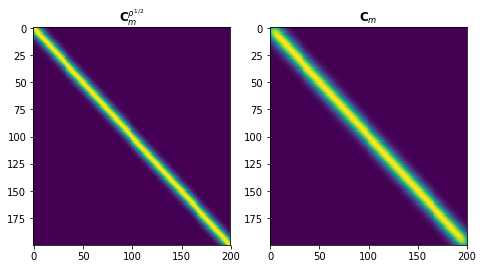

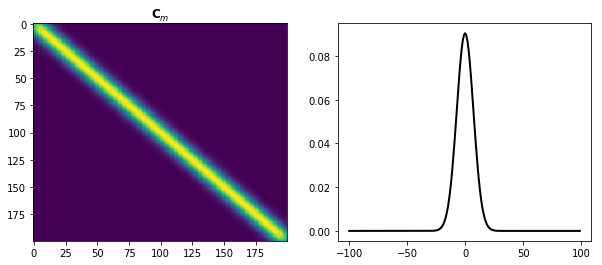

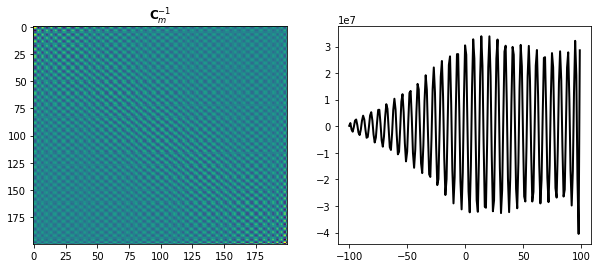

In [63]:
# Mean
x0 = 0.1 * np.ones_like(x)

# Correlation and covariance functions
corrrange = .05
sigma_m = 1e-1
taxis = np.arange(nt)*dt

corr_sqrt = np.exp(-3*(taxis)**2/corrrange**2)
Corr_sqrt = toeplitz(corr_sqrt)
Corr = np.dot(Corr_sqrt.T, Corr_sqrt)
Std = np.diag(sigma_m*np.ones(Corr.shape[0]))
Cm = np.dot(Std, np.dot(Corr, Std))

fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(131)
ax1.imshow(Corr_sqrt, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{\rho^{1/2}}$")
ax1.axis('tight')
ax2 = plt.subplot(132)
ax2.imshow(Corr, interpolation='nearest')
ax2.set_title(r"$\mathbf{C}_m^{\rho}$")
ax2.axis('tight')
ax3 = plt.subplot(132)
ax3.imshow(Cm, interpolation='nearest')
ax3.set_title(r"$\mathbf{C}_m$")
ax3.axis('tight');

# Inverse
Corr_sqrt_inv = np.linalg.pinv(Corr_sqrt, rcond=1e-10)
Corr_inv = np.linalg.pinv(Corr, rcond=1e-10)
Cm_inv = np.linalg.pinv(Cm, rcond=1e-10)

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
ax1.imshow(Cm, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{}$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.plot(np.arange(-nt//2, nt//2), Cm[nt//2], 'k', lw=2)

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
ax1.imshow(Cm_inv, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{-1}$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.plot(np.arange(-nt//2, nt//2), Cm_inv[nt//2], 'k', lw=2);

Let's start by solving the problem explicitely

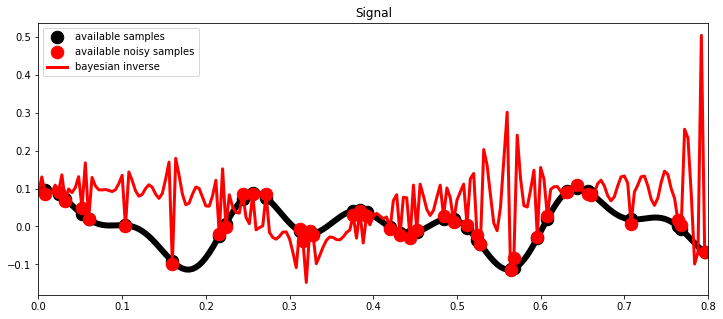

In [64]:
# Problem
R = np.zeros((ntsub, nt))
R[np.arange(ntsub), iava] = 1

# Data covariance
sigma=1e-2
Cd_inv = (1./sigma**2) * np.eye(ntsub)
Cd_half_inv = (1./sigma) * np.eye(ntsub)

xbayes = lstsq(np.dot(R.T, np.dot(Cd_inv, R)) + Cm_inv, 
               np.dot(R.T, np.dot(Cd_inv, yn)) + np.dot(Cm_inv, x0), cond=1e-10)[0]

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xbayes, 'r', lw=3, label='bayesian inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

We see that the inverse is very ill-posed. Alternatively, we directly define the inverse as a roughening operator

In [65]:
Cm_inv = -np.diag(np.ones(nt-1),k=1) + 2*np.diag(np.ones(nt)) - np.diag(np.ones(nt-1),-1) 
Cm_inv = 1e5*np.dot(Cm_inv.T, Cm_inv)

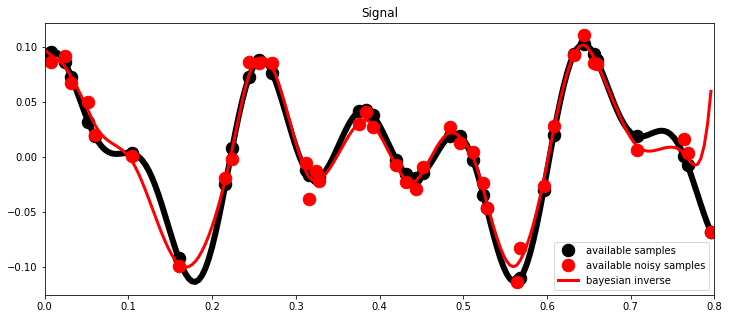

In [66]:
xbayes = lstsq(np.dot(R.T, np.dot(Cd_inv, R)) + Cm_inv, 
               np.dot(R.T, np.dot(Cd_inv, yn)) + np.dot(Cm_inv, x0), cond=1e-10)[0]

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xbayes, 'r', lw=3, label='bayesian inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

Alternatively we can still define the covariances (instead of their inverse) but we need a modified inverse equation:
    
$$\mathbf{m} = \mathbf{m_0} + (\mathbf{R} \mathbf{C}_m \mathbf{R}^T + \mathbf{C}_d)^{-1} (\mathbf{d} - \mathbf{R} \mathbf{m_0})$$

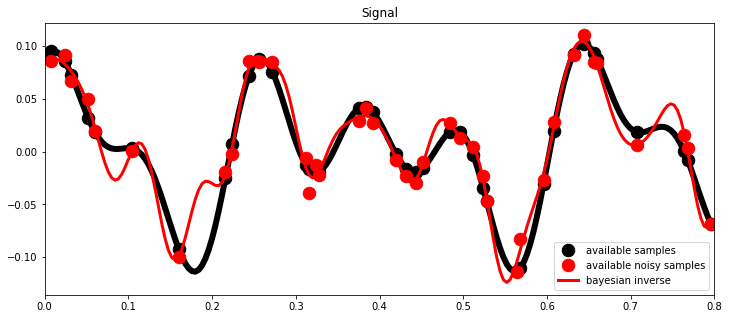

In [67]:
# Data covariance
Cd = sigma**2 * np.eye(ntsub)

xbayes = \
    x0 + np.dot(Cm, np.dot(R.T, np.dot(np.linalg.inv(np.dot(R, np.dot(Cm, R.T)) + Cd), 
                                        yn - np.dot(R, x0))))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xbayes, 'r', lw=3, label='bayesian inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

Since we however do not want to create those matrices explicitely we create equivalent linear operators

In [68]:
Cm_op = \
    (sigma_m * pylops.Identity(nt)) * \
    pylops.signalprocessing.Convolve1D(nt, Corr[nt//2, nt//2-50:nt//2+51], offset=50) * \
    (sigma_m * pylops.Identity(nt))
Cd_op = (sigma**2) * pylops.Identity(ntsub)

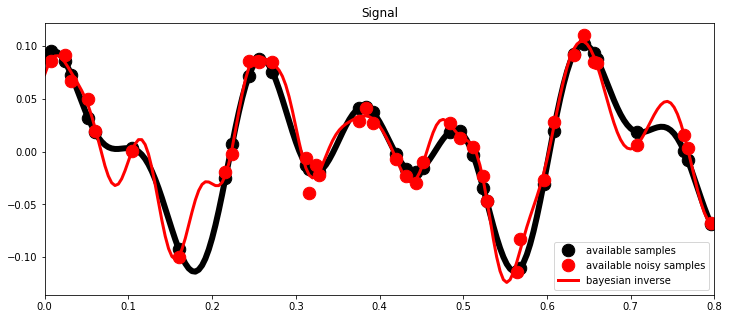

In [69]:
xbayes = x0 + Cm_op * Rop.H * (lsqr(Rop * Cm_op * Rop.H + Cd_op, yn - Rop*x0, iter_lim=400)[0])

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xbayes, 'r', lw=3, label='bayesian inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

### Ensamble Bayesian inversion

Let's not try to do the same but we sample a number of possible prior models and use them as starting guesses. We know our data is composed of 3 sinusoids, but we have not exact knowledge of the frequencies, neither the amplitudes, nor the phase.

We can write:

$$f_i \sim \mathcal{N}(f_{0,i}, \sigma_{f,i}) \quad \forall i=1,2,3$$

$$a_i \sim \mathcal{N}(a_i, \sigma_{a,i}) \quad \forall i=1,2,3$$

$$\phi_i \sim \mathcal{N}(\phi_i, \sigma_{\phi,i}) \quad \forall i=1,2,3$$

In [70]:
def prior_realization(f0, a0, phi0, sigmaf, sigmaa, sigmaphi, dt, nt, nfft):
    # draw input signal parameters
    dt = 0.004
    t = np.arange(nt)*dt
    f = np.fft.rfftfreq(nfft, dt)
    df = f[1]-f[0]
    ifreqs = [int(np.random.normal(f, sigma)/df) for f, sigma in zip(f0, sigmaf)]
    amps = [np.random.normal(a, sigma) for a, sigma in zip(a0, sigmaa)]
    phis = [np.random.normal(phi, sigma) for phi, sigma in zip(phi0, sigmaphi)]
    # input signal in frequency domain
    X = np.zeros(nfft//2+1, dtype='complex128')
    X[ifreqs] = np.array(amps).squeeze() * np.exp(1j * np.deg2rad(np.array(phis))).squeeze()

    # input signal in time domain
    FFTop = pylops.signalprocessing.FFT(nt, nfft=nfft, real=True)
    x = FFTop.H*X
    return x

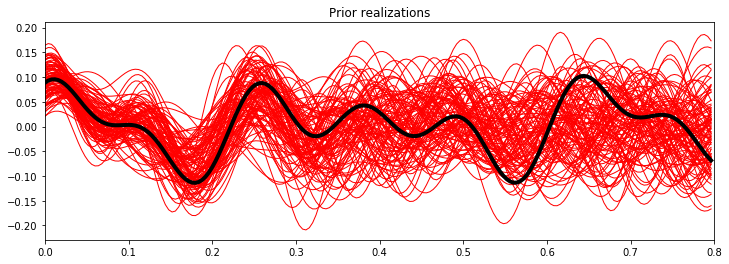

In [71]:
nreals=100
f0 = [5, 3, 8]
sigmaf = [0.5, 1., 0.6]
a0 = [1., 1., 1.]
sigmaa = [0.1, 0.5, 0.6]
phi0 = [-90., 0., 0.]
sigmaphi = [0.1, 0.2, 0.4]
sigma=1e-2

x = prior_realization(f0, a0, phi0, [0,0,0], [0,0,0], [0,0,0], dt, nt, nfft)
xs = np.array([prior_realization(f0, a0, phi0, sigmaf, sigmaa, sigmaphi, dt, nt, nfft) \
               for _ in range(nreals)])

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(t, xs.T, 'r', lw=1)
ax.plot(t, x, 'k', lw=4)
ax.set_title('Prior realizations')
ax.set_xlim(0, 0.8);

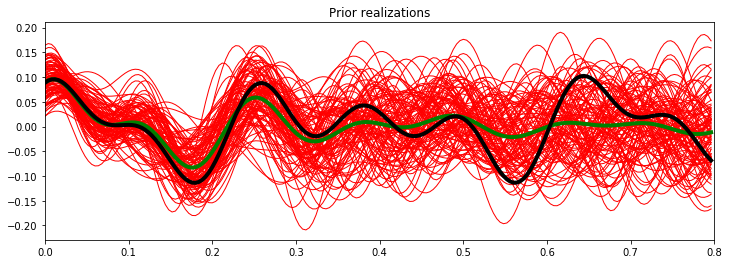

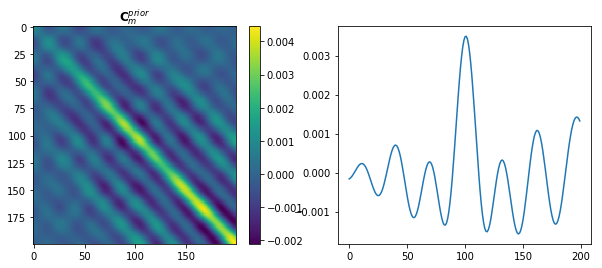

In [72]:
# Estimate covariance and mean in time domain
x0_sample = np.average(xs, axis=0)
Cm_sample = ((xs - x0_sample).T @ (xs - x0_sample))/nreals

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(t, xs.T, 'r', lw=1)
ax.plot(t, x0_sample, 'g', lw=4)
ax.plot(t, x, 'k', lw=4)
ax.set_title('Prior realizations')
ax.set_xlim(0, 0.8);

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
im = ax1.imshow(Cm_sample, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{prior}$")
plt.colorbar(im, ax=ax1)
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.plot(Cm_sample[nt//2]);

As you can see the covariance here is not that different from what we wildly guessed before. However because of the limited number of realizations. Moreover, having a complete covariance matrix would not be efficient. What we can do is to average $2N+1$ elements around the main diagonal for each column (apart from edges).

**Note**: *this matrix may be very large and not fit in memory, in this case you may want to compute it row-by-row and only store the values to be averaged*

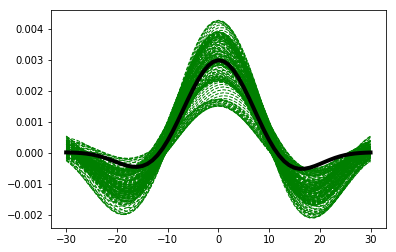

In [73]:
N=30
diags = np.array([Cm_sample[i, i-N:i+N+1] for i in range(N, nt-N)])
diag_ave = np.average(diags, axis=0)

# we add a taper at the end to avoid edge effects
diag_ave *= np.hamming(2*N+1)

plt.figure()
plt.plot(np.arange(-N, N + 1), diags.T, '--g', lw=1);
plt.plot(np.arange(-N, N + 1), diag_ave, 'k', lw=4);

Let's build again the prior covariances

In [74]:
Cm_op = \
    pylops.signalprocessing.Convolve1D(nt, diag_ave, offset=N) 
Cd_op = sigma**2 * pylops.Identity(ntsub)

Create data

In [75]:
n = np.random.normal(0, sigma, nt)
y = Rop*x
yn = Rop*(x + n)
ymask = Rop.mask(x)
ynmask = Rop.mask(x + n)

Invert

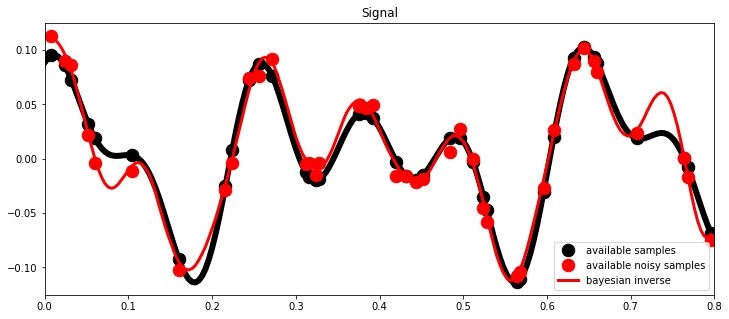

In [76]:
xbayes = x0 + Cm_op * Rop.H * (lsqr(Rop * Cm_op * Rop.H + Cd_op, yn - Rop*x0, iter_lim=400)[0])

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, xbayes, 'r', lw=3, label='bayesian inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

Let's now do something similar but with different starting guesses taken from our prior realizations

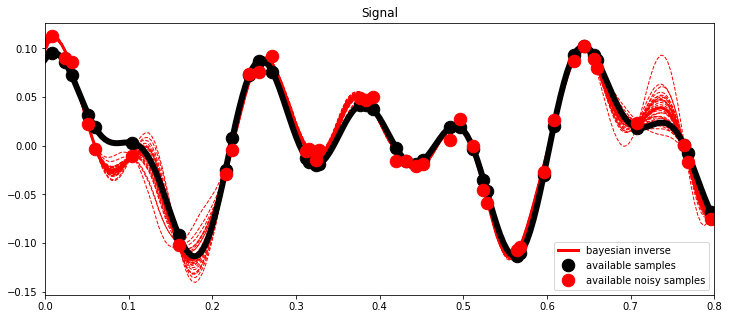

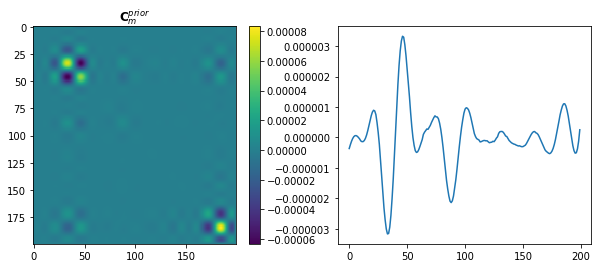

In [77]:
xbayesreals = [x0 + Cm_op * Rop.H * (lsqr(Rop * Cm_op * Rop.H + Cd_op, yn - Rop*x0, iter_lim=400)[0]) 
          for x0 in xs[:30]]

xbayesreals = np.array(xbayesreals)

# Estimate posterior covariance and mean in time domain
x0_post = np.average(xbayesreals, axis=0)
Cm_post = ((xbayesreals - x0_post).T @ (xbayesreals - x0_post))/nreals

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, xbayesreals.T, '--r', lw=1)
ax.plot(t, x0_post, 'r', lw=3, label='bayesian inverse')
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, ynmask, '.r', ms=25, label='available noisy samples')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
im = ax1.imshow(Cm_post, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{prior}$")
plt.colorbar(im, ax=ax1)
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.plot(Cm_post[nt//2]);